In [3]:
%clear
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d, fftconvolve

In [4]:
camara_pixel_size = 5000 # nm
camara_pixels_number = 256
camara_size = camara_pixel_size * camara_pixels_number 
NA = 1.4 # numerical aperture
MA = 1000 # magnification
physical_pixel_size = camara_pixel_size / MA 
physical_size = camara_size / MA 
excitation_wavelength = 488 # nm
emission_wavelength = 520 # nm
#diffraction_limit = 0.61 * wavelength / NA 

In [5]:
def generate_psf(camara_pixels_number, physical_pixel_size, wavelength, NA):
    # 计算频率范围
    freq = np.fft.fftfreq(camara_pixels_number, d=physical_pixel_size)
    fx, fy = np.meshgrid(freq, freq)
    f_r = np.sqrt(fx**2 + fy**2)
    
    # 计算截止频率
    cutoff_frequency = 2 * NA / wavelength
    
    # 生成光瞳函数
    pupil_function = f_r <= cutoff_frequency

    # 计算点扩散函数
    psf = np.abs(ifftshift(ifft2(fftshift(pupil_function))))**2
    psf /= psf.sum()  # 归一化
    
    return psf


In [6]:
line_pairs_spacing = [60, 90, 120, 150, 180, 210] # nm
line_pairs_spacing = np.array(line_pairs_spacing)
line_pairs_spacing = line_pairs_spacing * 1000 / camara_pixel_size    # in pixel size

In [7]:
def generate_line_pairs(camara_pixels_number, line_spacing = 20, line_width = 1, line_length = 100):
    
    # 创建一个的黑色图像
    image_array = np.zeros((camara_pixels_number, camara_pixels_number), dtype=np.uint32)

    # 线的间距和宽度和长度
    line_spacing = round(line_spacing)
    line_width = round(line_width)
    line_length = round(line_length)
    
    # 计算线的位置
    center_x = image_array.shape[1] // 2
    center_y = image_array.shape[0] // 2

    # 第一条线的起始和结束位置
    line1_start_x = center_x - line_spacing // 2 - line_width
    line1_end_x = line1_start_x + line_width
    line1_start_y = center_y - line_length // 2
    line1_end_y = line1_start_y + line_length

    # 第二条线的起始和结束位置
    line2_start_x = center_x + line_spacing // 2
    line2_end_x = line2_start_x + line_width
    line2_start_y = center_y - line_length // 2
    line2_end_y = line2_start_y + line_length

    # 绘制第一条线
    image_array[line1_start_y:line1_end_y, line1_start_x:line1_end_x] = 2**32 - 1

    # 绘制第二条线
    image_array[line2_start_y:line2_end_y, line2_start_x:line2_end_x] = 2**32 - 1
    
    return image_array.astype(np.float64)

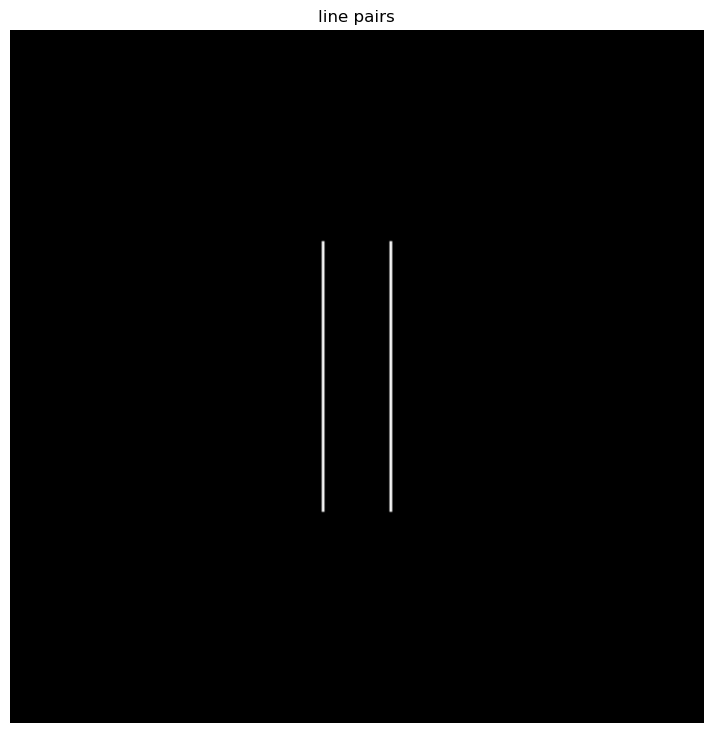

In [8]:
images = [generate_line_pairs(camara_pixels_number, spacing) for spacing in line_pairs_spacing]

ground_truth = images[2]
#ground_truth = np.hstack(images)
plt.figure(figsize=(18, 9))
plt.imshow(ground_truth, cmap='gray')
plt.title("line pairs")
plt.axis('off')
plt.show()

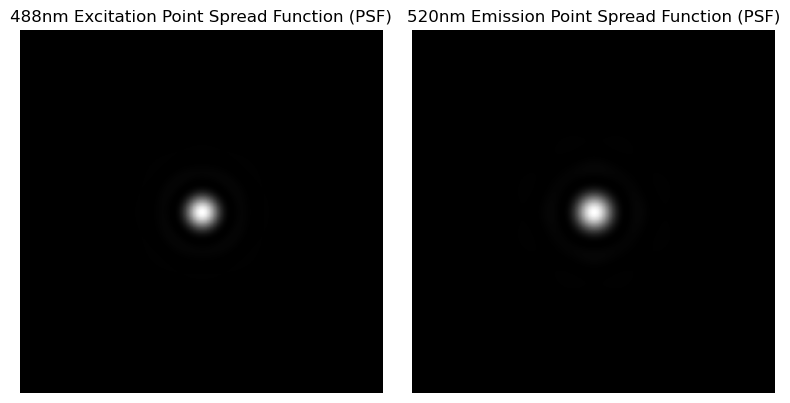

In [9]:
excitation_psf = generate_psf(camara_pixels_number, physical_pixel_size, excitation_wavelength, NA)
emission_psf = generate_psf(camara_pixels_number, physical_pixel_size, emission_wavelength, NA)

# 显示激发点扩散函数和发射点扩散函数并列
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# 激发点扩散函数
axes[0].imshow(excitation_psf, cmap='gray')
axes[0].set_title("488nm Excitation Point Spread Function (PSF)")
axes[0].axis('off')

# 发射点扩散函数
axes[1].imshow(emission_psf, cmap='gray')
axes[1].set_title("520nm Emission Point Spread Function (PSF)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

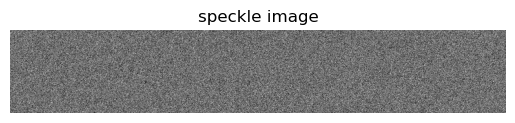

In [10]:
# 生成256x256的随机散斑图片，像素值呈现半正态分布，平均值为2**31，方差为2**10
speckle_image = np.round(np.abs(np.random.normal(2**31, 2**10, (128, 128*6))))

# 显示其中一张随机散斑图片
plt.imshow(speckle_image, cmap='gray')
plt.title("speckle image")
plt.axis('off')  # 不显示坐标轴
plt.show()

In [11]:
print(speckle_image.dtype)

float64


221867719.74833363


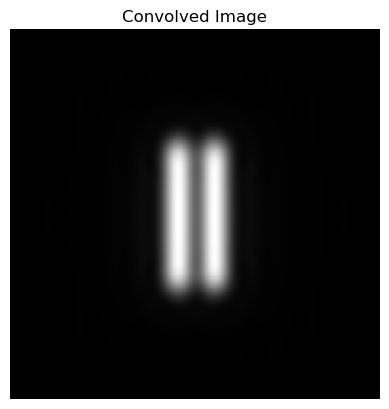

In [12]:
# 对 ground_truth 和 psf 进行卷积
convolved_image = fftconvolve(ground_truth, excitation_psf, mode='same')
print(np.max(convolved_image))
# 显示卷积后的图像
plt.imshow(convolved_image, cmap='gray')
plt.title("Convolved Image")
plt.axis('off')
plt.show()